This post is about building a database from the [Commitment Of Traders report for FOREX trading](https://www.babypips.com/learn/forex/commitment-of-traders-report). The data I used is reported positions on futures contracts for a number of foreign currencies. Here I focus on those currencies making up the major pairs. From there it's easy to extend the list of currencies to any available in the COT report (see below for a fragment).
<img src="files/cotfiles/samplecot.png" width="600" height="1200" /img>
<!--TEASER END-->

My goal is 3-fold. 

    1. learn to get both historic and latest COT reports and store them.
    2. develop a daemon to automatically download data and update my database
    3. use the data to make a simple indicator. Yes, they're already available,But I learn by doing.

This post will focus on 1.

I stole some of the code I used from [here](https://github.com/jonromero/commitment_of_traders)
As always, start by importing some useful libraries

In [20]:
import requests
import pandas as pd
from tqdm import tqdm_notebook # for-loop progress bar
import locale # useful for converting comma-formatted number strings to int/float
import matplotlib.pyplot as pl
from matplotlib import rcParams
from datetime import datetime, timedelta
import sys
import os 
% matplotlib inline

In [2]:
print("I'm using python %s " %sys.version.split('|')[0])
print("and pandas version: %s" %pd.__version__)

I'm using python 3.6.2  
and pandas version: 0.20.2


The general CFTC page where data are to be found are [here]( http://www.cftc.gov/marketreports/commitmentsoftraders/index.htm). The latest report can be found [here](http://www.cftc.gov/dea/futures/deacmesf.htm). More explanations can be found [here](https://www.babypips.com/learn/forex/3-simple-steps-to-access-the-cot-report) and subsequent pages. 
First make a list of the contracts (as specified in the COT report) I'm interested in:

   * 'CANADIAN DOLLAR '
   * 'SWISS FRANC '
   * 'BRITISH POUND '
   * 'JAPANESE YEN '
   * 'EURO FX'
   * 'AUSTRALIAN DOLLAR '
   * 'NEW ZEALAND DOLLAR '

I'll store long and short data for **non-commercials** (hedgers), **commercials** ( large speculators), **nonreportable positions** (nrp in the dataframes, i.e. small speculators)

Next is to break down what I want to do into small functions:

In [15]:
def GetHistoricUrl(tuesday):
    """
    Get URL to historic COT reports using a baseline and a date
    
    inputs:
    -------
     tuesday
        date (day, month, year) corresponding to a tuesday (day on which COT reports appear to be filed)
        datetime object
        
    outputs:
    --------
    historicUrl
        link to historic report
        string
    """
    
    baseUrl = 'http://www.cftc.gov/files/dea/cotarchives/%year%/futures/deacmesf%month%%day%%Year%.htm'
    strTuesday = str(tuesday.month).zfill(2) + "/" + str(tuesday.day).zfill(2) + "/" + str(tuesday.year)
    month, day, year = strTuesday.split('/')
    historicUrl = baseUrl.replace('%year%',
                                year).replace('%month%',
                                              month). replace('%day%',
                                                              day).replace('%Year%',
                                                                           year[2:])
    return historicUrl

def GetTuesdays(start, end):
    """
    From the 
    """
    start, end = datetime(2005, 1, 4), datetime.today()
    days = (start + timedelta(days=i) for i in range((end - start).days + 1))
    tuesdays = [d for d in days if d.weekday() == 1]
    return tuesdays

def DownloadData(date='latest'):
    if date == 'latest':
        url = 'http://www.cftc.gov/dea/futures/deacmesf.htm'
    else:
        url = GetHistoricUrl(date)
    rep = requests.get(url)
    if rep.url == 'http://www.cftc.gov:80/Error/index.htm':
        print("Data not found for %s @ url: %s" % (date.date(), url))
        return None
    else:
        return rep.text.split('\n')

def GetData(textData, target, df, dt):
    for idx, line in enumerate(textData):
        if target in line:
            data = textData[idx:idx+19]
            current = " ".join(data[9].split()).split(" ")
            changes = " ".join(data[12].split()).split(" ")
            try:
                df.loc[dt, ('non-commercial', 'current', 'long')] = locale.atoi(current[0])
                df.loc[dt, ('non-commercial', 'current', 'short')] = locale.atoi(current[1])
                df.loc[dt, ('commercial', 'current', 'long')] = locale.atoi(current[3])
                df.loc[dt, ('commercial', 'current', 'short')] = locale.atoi(current[4])
                df.loc[dt, ('nrp', 'current', 'long')] = locale.atoi(current[7])
                df.loc[dt, ('nrp', 'current', 'short')] = locale.atoi(current[8])
            except ValueError:
                print('current data not found for %s on %s' % (target, dt))
            try:
                df.loc[dt, ('non-commercial', 'changes', 'long')] = locale.atoi(changes[0])
                df.loc[dt, ('non-commercial', 'changes', 'short')] = locale.atoi(changes[1])
                df.loc[dt, ('commercial', 'changes', 'long')] = locale.atoi(changes[3])
                df.loc[dt, ('commercial', 'changes', 'short')] = locale.atoi(changes[4])
                df.loc[dt, ('nrp', 'changes', 'long')] = locale.atoi(changes[7])
                df.loc[dt, ('nrp', 'changes', 'short')] = locale.atoi(changes[8])
            except ValueError as e:
                print('changes data not found for %s on %s' % (target, dt))
    return None

def GetDataDebug(textData, target, df, dt):
    for idx, line in enumerate(textData):
        if target in line:
            data = textData[idx:idx+19]
            current = " ".join(data[9].split()).split(" ")
            changes = " ".join(data[12].split()).split(" ")
            return current, changes, data

def MakeDFTemplate(tuesdays):
    df = pd.DataFrame(index=pd.date_range(start=tuesdays[0], 
                                          end=tuesdays[-1], freq='W-TUE'),
                      columns=pd.MultiIndex.from_product([['non-commercial', 'commercial', 'nrp'],
                                                          ['current', 'changes'],
                                                          ['long', 'short']]))
    return df

def SaveData(name, df):
    COTDATDIR = os.getenv('FX_COT_DATA_DIR')
    with open(os.path.join(COTDATDIR,'COT_%s.pkl' % name.strip()), 'wb') as fh:
        df.to_pickle(fh)

In [16]:
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
startDate, endDate = datetime(2005, 1, 4), datetime(2017, 7, 15)
allTuesdays = GetTuesdays(startDate, endDate)
dfCAD = MakeDFTemplate(allTuesdays).copy(deep=True)
dfSF = MakeDFTemplate(allTuesdays).copy(deep=True)
dfBP = MakeDFTemplate(allTuesdays).copy(deep=True)
dfJY = MakeDFTemplate(allTuesdays).copy(deep=True)
dfEUR = MakeDFTemplate(allTuesdays).copy(deep=True)
dfAUD = MakeDFTemplate(allTuesdays).copy(deep=True)
dfNZD = MakeDFTemplate(allTuesdays).copy(deep=True)
contractDict = {'CANADIAN DOLLAR ': dfCAD, 'SWISS FRANC ': dfSF, 
                'BRITISH POUND ': dfBP, 'JAPANESE YEN ': dfJY, 
                'EURO FX ': dfEUR, 'AUSTRALIAN DOLLAR ': dfAUD,
                'NEW ZEALAND DOLLAR ': dfNZD}
for tuesday in tqdm_notebook(allTuesdays):
    textDataList = DownloadData(tuesday)
    if textDataList:
        for contract, df in contractDict.items():
            GetData(textDataList, contract, df, tuesday)
latestDataList = DownloadData()
for contract, df in contractDict.items():
    GetData(latestDataList, contract, df, tuesday)
    SaveData(contract, df)

changes data not found for NEW ZEALAND DOLLAR  on 2005-03-08 00:00:00
changes data not found for NEW ZEALAND DOLLAR  on 2005-03-29 00:00:00
changes data not found for NEW ZEALAND DOLLAR  on 2005-08-16 00:00:00
Data not found for 2005-08-30 @ url: http://www.cftc.gov/files/dea/cotarchives/2005/futures/deacmesf083005.htm
changes data not found for NEW ZEALAND DOLLAR  on 2005-10-11 00:00:00
changes data not found for NEW ZEALAND DOLLAR  on 2005-12-06 00:00:00
Data not found for 2006-07-04 @ url: http://www.cftc.gov/files/dea/cotarchives/2006/futures/deacmesf070406.htm
changes data not found for NEW ZEALAND DOLLAR  on 2006-07-11 00:00:00
Data not found for 2007-01-02 @ url: http://www.cftc.gov/files/dea/cotarchives/2007/futures/deacmesf010207.htm
Data not found for 2007-12-25 @ url: http://www.cftc.gov/files/dea/cotarchives/2007/futures/deacmesf122507.htm
Data not found for 2008-01-01 @ url: http://www.cftc.gov/files/dea/cotarchives/2008/futures/deacmesf010108.htm
Data not found for 2008-1

There are some missing data as the messages indicate, but since that's out of over 650 reports, that seems pretty minor.
To verify this has gone well, I'll load the stored 'CANADIAN DOLLAR' data, take a look at the first few lines of the table, and plot some of the data

In [18]:
dfcad = pd.read_pickle('/Users/PoFA/DATAFILES/FX/COT/COT_CANADIAN DOLLAR.pkl')

In [19]:
dfcad.head()

non-commercial                       commercial                 \
                  current        changes           current        changes   
                     long  short    long  short       long  short    long   
2005-01-04          20448  10786    1233  -2295      20814  47151    3215   
2005-01-11          19317   9424   -1131  -1362      22579  47479    1765   
2005-01-18          19773  14273     456   4849      29262  49283    6683   
2005-01-25          17352  14699   -2421    426      33085  47224    3823   
2005-02-01          12127  10858   -5225  -3841      37013  50419    3928   

                      nrp                        
                  current        changes         
            short    long  short    long  short  
2005-01-04   5926   29452  12777     461   1278  
2005-01-11    328   27546  12539   -1906   -238  
2005-01-18   1804   27947  13426     401    887  
2005-01-25  -2059   27960  16474      13   3048  
2005-02-01   3195   27470  15333    -490  -1141

Now I'll plot the net positions (long, +ve; short, -ve) for the large speculators and hedgers.

In [25]:
dfcadNet = pd.DataFrame(index=dfcad.index)
dfcadNet['net_commercial'] = dfcad.loc[:,('commercial', 'current', 
                                          'long')] - dfcad.loc[:, ('commercial', 'current', 
                                                                   'short')]
dfcadNet['net_hedgers'] = dfcad.loc[:,('non-commercial', 'current',
                                       'long')] - dfcad.loc[:, ('non-commercial', 'current',
                                                               'short')]

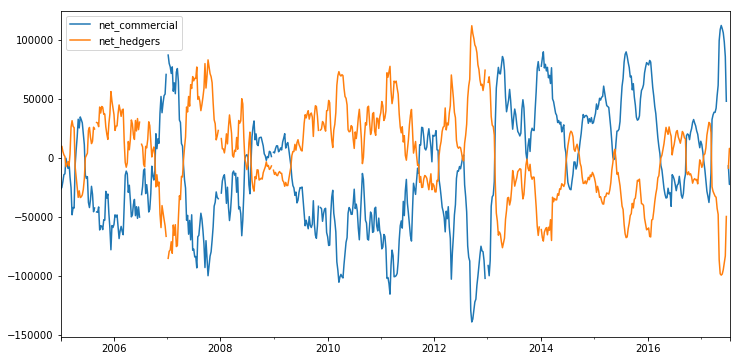

In [26]:
dfcadNet.plot(y=['net_commercial', 'net_hedgers'], figsize=(12,6));

The mirror image pattern suggests all is well. That's it for this post. Next I'll work on building a daemon for automatic downloads and develop an indicator. May the pips be with you!